# Generate embeddings with Vertex AI Embeddings API

> Generate embeddings for each doc/chunk, to extract semantic meaning of chunks

Embeddings are condensed representations of data that retain the information from the data. They are represented by a vector of numbers, usually floats, like `[0, 1, 0, 1]` or `[0.63475, 0.234, ..., 0.2646]`. They are a trained/learned representation for data like text, images, and tables and served as preditions form these models. Based on the type of model that is used in training they can be very good at retaining latent information like semantic meaning in text, objects in images, and correlation in tables

In [4]:
! cd .. && tree

.
├── README.md
├── notebooks
│   └── [JT]_grounded_rag.ipynb
├── requirements.txt
└── src
    ├── display_utils.py
    ├── docai_langchain_utils.py
    ├── gcs_loader.py
    └── vvs_utils.py

2 directories, 7 files


## imports

In [4]:
from typing import TYPE_CHECKING, Iterator, List, Optional, Sequence
import os, shutil, glob
import asyncio
import json
import matplotlib.pyplot as plt
import numpy as np


import vertexai
import vertexai.language_models # for text embedding models
from google.cloud import documentai, aiplatform, bigquery, storage, discoveryengine

print(f"BigQuery SDK version = {bigquery.__version__}")
print(f"Vertex AI SDK version = {vertexai.__version__}")
print(f"Document AI API version = {documentai.__version__}")
print(f"Discovery Engine API version = {discoveryengine.__version__}")

# this repo
import sys
sys.path.append("..")
from src import display_utils, docai_utils, gcs_loader, vvs_utils

BigQuery SDK version = 3.25.0
Vertex AI SDK version = 1.71.0
Document AI API version = 2.35.0
Discovery Engine API version = 0.11.14


## config

In [21]:
PREFIX="mortgage-ball"

In [22]:
PROJECT_ID = "hybrid-vertex"
REGION = "us-central1"
LOCATION = REGION.split('-')[0]
GCS_BUCKET_URI = f"gs://{PREFIX}-bucket"
BUCKET = GCS_BUCKET_URI.replace("gs://", "")

# SERIES = 'applied-genai'
EXPERIMENT = 'embeddings-api'
LOCAL_DIR = f"files/{EXPERIMENT}"

# Set BigQuery Names
BQ_PROJECT = PROJECT_ID
BQ_DATASET = f"{PREFIX}_rag".replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # pick a multi-region

# vertexai.init(project=PROJECT_ID, location=REGION)
# print(f"Vertex AI SDK initialized.")

print(f"LOCATION       = {LOCATION}")
print(f"GCS_BUCKET_URI = {GCS_BUCKET_URI}")
print(f"BUCKET         = {BUCKET}")
print(f"EXPERIMENT     = {EXPERIMENT}")
print(f"LOCAL_DIR      = {LOCAL_DIR}")
print(f"BQ_DATASET     = {BQ_DATASET}")
print(f"BQ_REGION      = {BQ_REGION}")

LOCATION       = us
GCS_BUCKET_URI = gs://mortgage-ball-bucket
BUCKET         = mortgage-ball-bucket
EXPERIMENT     = embeddings-api
LOCAL_DIR      = files/embeddings-api
BQ_DATASET     = mortgage_ball_rag
BQ_REGION      = us


In [7]:
# clients
vertexai.init(project = PROJECT_ID, location = REGION)
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

# gcs bucket
bucket = gcs.lookup_bucket(BUCKET)

In [8]:
if not os.path.exists(LOCAL_DIR):
    os.makedirs(LOCAL_DIR)

# Test for Examples

```
├── 01_ingest_rag.ipynb
├── 02_embeddings_rag.ipynb
├── 02_original_grounded_rag.ipynb
├── 0X_grounded_rag.ipynb
└── files
    ├── embeddings-api
    ├── lending
    └── mlb
        ├── document-chunks.jsonl
        ├── document.pdf
        └── small_document.pdf
```

In [13]:
local_dir = "files"
# !tree $local_dir

### Load and reveiw chunks

In [29]:
with open("files/mlb/document-chunks.jsonl", "r") as f:
    chunks = [json.loads(line) for line in f]
    
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

# Configfure Embedding Model

> Select onr of the [supported text embdding models](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings#supported-models)

In [30]:
embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

## Embedding Requests

### Single Instance

In [31]:
response = embedder.get_embeddings([chunks[0]['content']])
print(f"length of response: {len(response)}")

length of response: 1


In [32]:
response[0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

In [33]:
print(f"length of vectors: {len(response[0].values)}")

length of vectors: 768


In [34]:
response[0].statistics

TextEmbeddingStatistics(token_count=19.0, truncated=False)

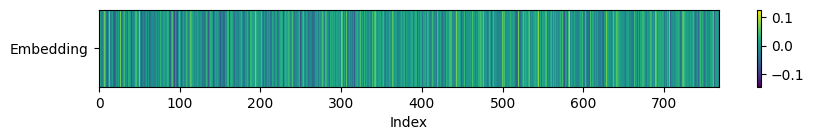

In [35]:
plt.figure(figsize=(10, 1))
plt.imshow([response[0].values], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0], ["Embedding"]) 
plt.colorbar()
plt.show()

### Multiple Instances, Single Request

In [36]:
n_instances = 10
response = embedder.get_embeddings([chunks[i]['content'] for i in range(n_instances)])

len(response)
response[0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

In [37]:
response[-1].values[0:10]

[0.012910179793834686,
 0.02096092514693737,
 -0.011132142506539822,
 0.018320411443710327,
 -0.028627533465623856,
 0.01824655383825302,
 0.065038301050663,
 0.05292586237192154,
 0.02120327204465866,
 -0.028758231550455093]

In [38]:
response[0].statistics

TextEmbeddingStatistics(token_count=19.0, truncated=False)

In [39]:
response[-1].statistics

TextEmbeddingStatistics(token_count=119.0, truncated=False)

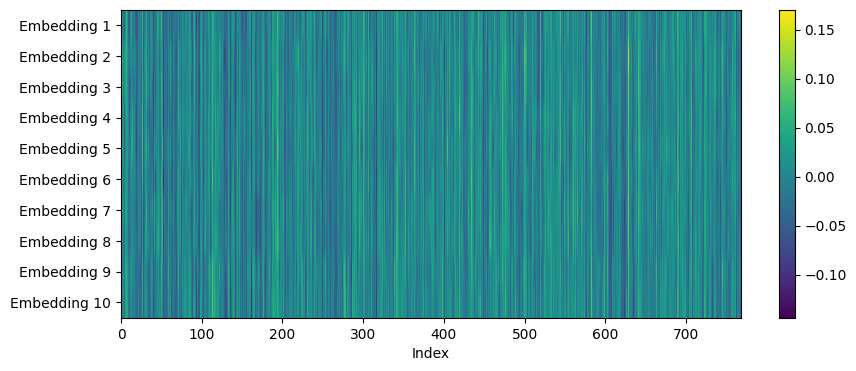

In [40]:
plt.figure(figsize=(10, 4))
plt.imshow([r.values for r in response], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks(list(range(n_instances)), [f"Embedding {i+1}" for i in range(n_instances)]) 
plt.colorbar()
plt.show()

### Async Request: Single

In [41]:
response = await embedder.get_embeddings_async([chunks[0]['content']])
len(response)

1

In [42]:
response[0].values[0:10]

[-0.0014270133106037974,
 0.0252088475972414,
 -5.299176336848177e-05,
 -0.043303824961185455,
 -0.02709619142115116,
 0.004390457645058632,
 0.06190471723675728,
 0.053955815732479095,
 0.008000040426850319,
 -0.05304357036948204]

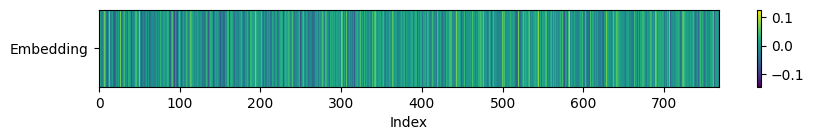

In [43]:
plt.figure(figsize=(10, 1))
plt.imshow([response[0].values], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0], ["Embedding"]) 
plt.colorbar()
plt.show()

## Embeddings For Different Tasks

The Verttex AI embeddings models can be [optimized for different task types](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/task-types). For instance, the default is `RETRIEVAL_QUERY` which is optimized for general matching and retrieval. These are specific task types that can be specified:

* `SEMANTIC_SIMILARITY` is optimized for assessing text similarity
* `CLASSIFICATION` is optimized for classifying text with preset lables
* `CLUSTERING` is optimized for clustering text based on similarity
* `RETRIEVAL_DOCUMENT` is optimized for document search
* `RETRIEVAL_QUERY` is optimzied for information retrieval (default)
* `QUESTION_ANSWERING` is optimzied for question answering where the query is a proper question with a "?"
* `FACT_VERIFICATION` is optimized for fact verification queries
* `CODE_RETRIEVAL_TASK` is optimized to find relevant code blocks
  * at first this is only for model `text-embedding-preview-0815`

**Try all task types for example chunk:**

In [44]:
task_types = [
    'SEMANTIC_SIMILARITY', 
    'CLASSIFICATION',
    'CLUSTERING',
    'RETRIEVAL_DOCUMENT',
    'RETRIEVAL_QUERY',
    'QUESTION_ANSWERING',
    'FACT_VERIFICATION'
]

task_responses = embedder.get_embeddings(
    [vertexai.language_models.TextEmbeddingInput(chunks[0]['content'], task) for task in task_types]
)

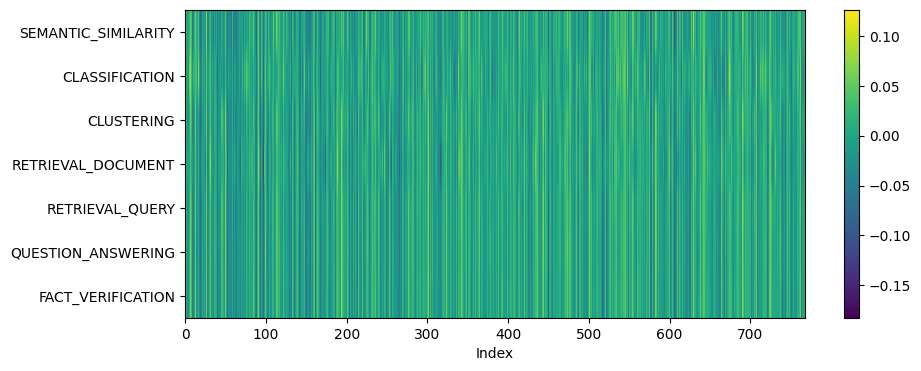

In [45]:
plt.figure(figsize=(10, 4))
plt.imshow([r.values for r in task_responses], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks(list(range(len(task_responses))), task_types) 
plt.colorbar()
plt.show()

## Embeeddings dimension size

In [46]:
dim_size_responses = await asyncio.gather(*[
    embedder.get_embeddings_async([chunks[0]['content']], output_dimensionality = d+1)
    for d in range(768)
])

In [47]:
# dim_size_responses[0][0].values
# dim_size_responses[1][0].values
dim_size_responses[2][0].values

[-0.0014270133106037974, 0.0252088475972414, -5.299176336848177e-05]

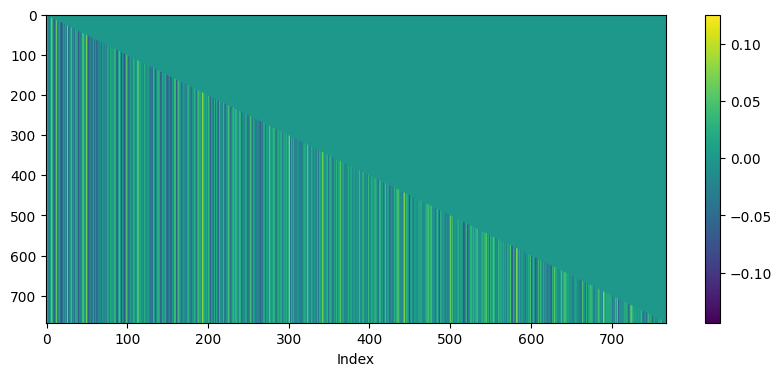

In [48]:
plt.figure(figsize=(10, 4))
plt.imshow([r[0].values +[0]*(768 - len(r[0].values)) for r in dim_size_responses], cmap='viridis', aspect='auto')
plt.xlabel('Index') 
plt.colorbar()
plt.show()

## Embeddings And Normalization

**How to Check For Normalization?**

Get a single embedding:

In [49]:
response = embedder.get_embeddings([chunks[0]['content']])

Convert the embedding from Python list to Numpy array for the calcuations:

In [50]:
embedding = np.array(response[0].values)

Verify the embedding is the expected dimension of 768:

In [51]:
embedding.shape

(768,)

If the embedding is already normalized then it would have magnitude 1. 

Below, the L2 norm is calculated and shows that it is essentially 1 with some error in the 6th decimal place:

In [52]:
np.linalg.norm(embedding, 2)

0.9999985004805458

Create the normalized embedding by dividng the embedding by its magnitude (calculated as the L2 norm):

In [53]:
embedding_normalized = embedding / np.linalg.norm(embedding, 2)

Compare the first few element of the embedding to the normalized embedding. Notice they are nearly identical:

In [54]:
embedding[0:10]

array([-1.42701331e-03,  2.52088476e-02, -5.29917634e-05, -4.33038250e-02,
       -2.70961914e-02,  4.39045765e-03,  6.19047172e-02,  5.39558157e-02,
        8.00004043e-03, -5.30435704e-02])

In [55]:
embedding_normalized[0:10]

array([-1.42701545e-03,  2.52088854e-02, -5.29918428e-05, -4.33038899e-02,
       -2.70962321e-02,  4.39046423e-03,  6.19048101e-02,  5.39558966e-02,
        8.00005242e-03, -5.30436499e-02])

Visualize the difference between the embedding and normalized embedding:

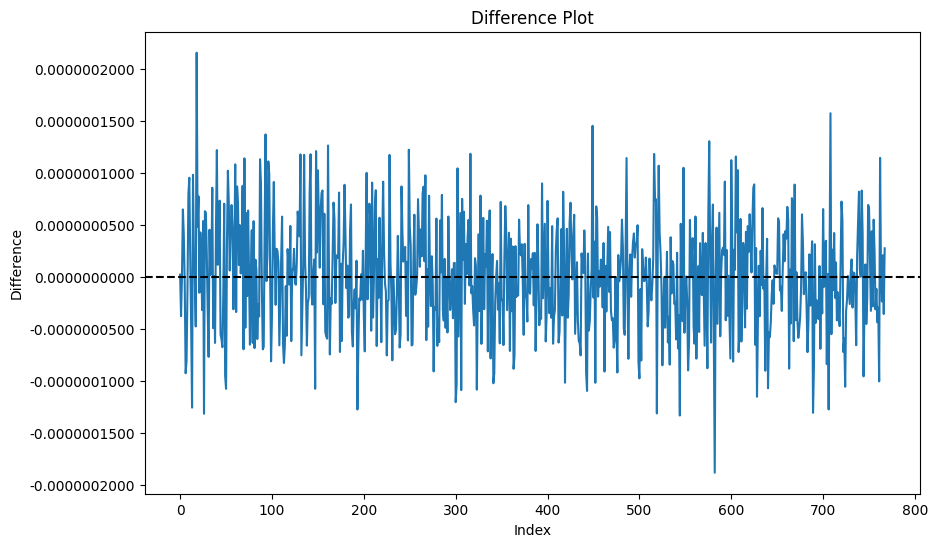

In [56]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
plt.plot(embedding - embedding_normalized)
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Difference Plot')
plt.axhline(y=0, color='k', linestyle='--')  # Add a zero line
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.10f'))
plt.show()

Calcualate the largest difference between the api response and the normalized version of the response:

In [59]:
max_diff = np.max(np.abs(embedding - embedding_normalized))
print(f"The maximum absolute difference is: {max_diff:.10f}")

The maximum absolute difference is: 0.0000002158


## Checking Embeddings From Different Task Optimziations

> What is the magnitude, norm, for each task type?

In [60]:
for t, task in enumerate(task_responses):
    print(f"The norm for the {task_types[t]} task type is {np.linalg.norm(np.array(task.values), 2)}")

The norm for the SEMANTIC_SIMILARITY task type is 0.9999987713022724
The norm for the CLASSIFICATION task type is 0.9999980236817011
The norm for the CLUSTERING task type is 0.9999985004805458
The norm for the RETRIEVAL_DOCUMENT task type is 0.9999993640838604
The norm for the RETRIEVAL_QUERY task type is 0.9999985004805458
The norm for the QUESTION_ANSWERING task type is 0.9999985168306245
The norm for the FACT_VERIFICATION task type is 0.9999984910619315


## Checking Embedding Of Different Dimensions

> Since the request for different dimension size returns a truncated list of the embedding for smaller dimensions the magnitudes are <1 for each dimension < 768.

In [61]:
dim_norms = [np.linalg.norm(np.array(r[0].values), 2) for r in dim_size_responses]
dim_sizes = range(1, len(dim_norms) + 1)

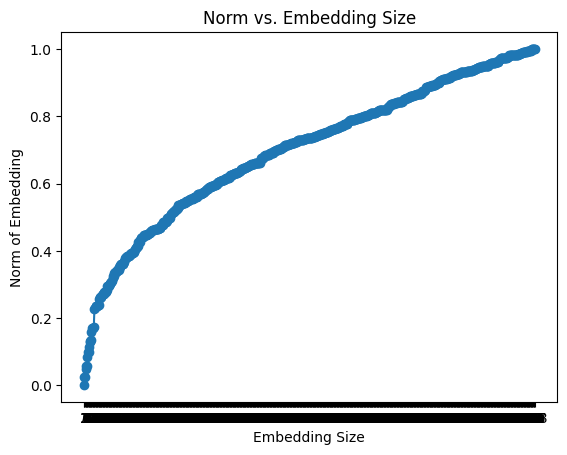

In [62]:
plt.plot(dim_sizes, dim_norms, marker='o')
plt.xlabel('Embedding Size')
plt.ylabel('Norm of Embedding')
plt.title('Norm vs. Embedding Size')
plt.xticks(dim_sizes)  # Show integer ticks on the x-axis
#plt.grid(True)
plt.show()

## Batch Embeddings

For non-latency sensitive requests the batch method is more effective for large numbers of embeddings.

The online requests above showed how to request single and multiple instances. With batch request the instances need to be separated and prepared as either JSONL files stored in GCS, or in BigQuery tables. Both of theses methods are shown below.

A single request can have up to 30,000 instances (prompts). The defautl qouta is up to 4 concurrent batch prediction jobs for

## JSONL On GCS

In [63]:
len(chunks)

866

In [64]:
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

### Prepare Input And Save To GCS

> The JSONL need to have a field named `content` with the text to be embedded. This is already present in the chunks

In [65]:
blob = bucket.blob(f'{PREFIX}/{EXPERIMENT}/input.jsonl')
jsonl_data = '\n'.join(json.dumps(chunk) for chunk in chunks)
blob.upload_from_string(jsonl_data, content_type = 'application/jsonl')
list(bucket.list_blobs(prefix = f"{PREFIX}/{EXPERIMENT}"))

[<Blob: mortgage-ball-bucket, mortgage-ball/embeddings-api/input.jsonl, 1730879509113295>]

### Embedding Model

The `embedder` object above is already an import of an embedding model. The batch predictions capability is current in the preview module and is loaded in this step. In the near future this should able to bypass.

In [66]:
from vertexai.preview import language_models

# batch_embedder = language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')
batch_embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

### Create Batch Embeddings Job

In [67]:
batch_gcs_job = batch_embedder.batch_predict(
    dataset = [f"gs://{bucket.name}/{blob.name}"],
    destination_uri_prefix = f"gs://{bucket.name}/{PREFIX}/{EXPERIMENT}"
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/934903580331/locations/us-central1/batchPredictionJobs/5445277838448001024
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/934903580331/locations/us-central1/batchPredictionJobs/5445277838448001024')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/5445277838448001024?project=934903580331
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/5445277838448001024 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/5445277838448001024 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/5445277838448001024 current state:
JobState.JOB_STATE_SUCCEEDED
BatchPredictionJob run completed. Resource name: projects/934903580331/locations/

In [68]:
batch_gcs_job.output_info.gcs_output_directory

'gs://mortgage-ball-bucket/mortgage-ball/embeddings-api/prediction-model-2024-11-06T07:51:56.243110Z'

In [70]:
path = '/'.join(batch_gcs_job.output_info.gcs_output_directory.split("/")[3:])

list(bucket.list_blobs(prefix = path))

[<Blob: mortgage-ball-bucket, mortgage-ball/embeddings-api/prediction-model-2024-11-06T07:51:56.243110Z/000000000000.jsonl, 1730879543438654>]

#### Retrieve Batch Predictions

In [71]:
batch_gcs_predictions = []

for blob in list(bucket.list_blobs(prefix = path)):
    jsonl_preds = blob.download_as_string().decode('utf-8')
    jsonl_preds = [json.loads(line) for line in jsonl_preds.splitlines()]
    batch_gcs_predictions += jsonl_preds
    
# len(batch_gcs_predictions)

batch_gcs_predictions[0]['instance']

{'page_headers': [],
 'source_block_ids': [],
 'page_span': {'page_end': '3', 'page_start': '2'},
 'page_footers': [],
 'content': '# OFFICIAL BASEBALL RULES\n\n## Official Baseball Rules 2023 Edition\n\n### JOINT COMPETITION COMMITTEE\n\n|-|-|-|\n| Bill DeWitt | Whit Merrifield | Austin Slater |\n| Jack Flaherty | Bill Miller | John Stanton, Chair |\n| Tyler Glasnow | Dick Monfort | Tom Werner |\n| Greg Johnson | Mark Shapiro |  |\n\nCommittee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball',
 'chunk_id': 'c2'}

In [72]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['statistics']

{'token_count': 125, 'truncated': False}

In [73]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['values'][0:10]

[0.008681542240083218,
 0.06999468058347702,
 0.003673204220831394,
 0.019888797774910927,
 0.016285404562950134,
 0.035664502531290054,
 0.06200747936964035,
 0.05597030743956566,
 0.0034793149679899216,
 -0.024485772475600243]

#### Process And Store Chunks With Embeddings
This section store the chunks with embeddings as JSONL in this repository.

In [74]:
with open(f'{LOCAL_DIR}/chunk-embeddings.jsonl', 'w') as f:
    for chunk in batch_gcs_predictions:
        f.write(json.dumps(chunk)+ '\n')
        
os.listdir(LOCAL_DIR)

['chunk-embeddings.jsonl']

## JSONL On GCS - For A Larger Set of Chunks

> In the [Large Document Processing - Document AI Layout Parser](https://github.com/statmike/vertex-ai-mlops/blob/315a89c3b3245ff2e08d2522cb24c6f5c3a0ebb1/Applied%20GenAI/Chunking/Large%20Document%20Processing%20-%20Document%20AI%20Layout%20Parser.ipynb) workflow, a large set of chunks was created form multiple large pdfs (over 1000 pages each). Batch text embeddings is a great solution for this volume of embeddings requests.

*Load Another Set of Chunks (larger):*

In [75]:
chunk_dir = "files/lending"

jsonl_files = glob.glob(f"{chunk_dir}/*.jsonl")
jsonl_files.sort()
jsonl_files

['files/lending/document-chunks-0000.jsonl',
 'files/lending/document-chunks-0001.jsonl',
 'files/lending/document-chunks-0002.jsonl',
 'files/lending/document-chunks-0003.jsonl',
 'files/lending/document-chunks-0004.jsonl',
 'files/lending/document-chunks-0005.jsonl',
 'files/lending/document-chunks-0006.jsonl',
 'files/lending/document-chunks-0007.jsonl',
 'files/lending/document-chunks-0008.jsonl',
 'files/lending/document-chunks-0009.jsonl']

In [76]:
chunks = []
for file in jsonl_files:
    with open(file, 'r') as f:
        chunks.extend([json.loads(line) for line in f])
len(chunks)

9042

### Review data locally...

In [77]:
len(chunks)

9042

In [78]:
chunks[0]

{'gse': 'fannie',
 'filename': 'fannie_part_0',
 'file_chunk_id': 'c1',
 'chunk_id': 'fannie_part_0_c1',
 'content': 'Fannie Mae'}

#### Prepare Input And Save To GCS

> The JSONL need to have a field named `content` with the text to be embedded. This is already present in the chunks.

In [79]:
blob = bucket.blob(f'{PREFIX}/{EXPERIMENT}/input2.jsonl')
jsonl_data = '\n'.join(json.dumps(chunk) for chunk in chunks)
blob.upload_from_string(jsonl_data, content_type = 'application/jsonl')
list(bucket.list_blobs(prefix = f"{PREFIX}/{EXPERIMENT}"))

[<Blob: mortgage-ball-bucket, mortgage-ball/embeddings-api/input.jsonl, 1730879509113295>,
 <Blob: mortgage-ball-bucket, mortgage-ball/embeddings-api/input2.jsonl, 1730879718120413>,
 <Blob: mortgage-ball-bucket, mortgage-ball/embeddings-api/prediction-model-2024-11-06T07:51:56.243110Z/000000000000.jsonl, 1730879543438654>]

*The embedder object above is already an import of an embedding model. The batch predictions capability is current in the preview module and is loaded in this step. In the near future this should able to bypass.*

In [80]:
batch_embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')

### Create batch embeddings job

In [82]:
batch_gcs_job = batch_embedder.batch_predict(
    dataset = [f"gs://{bucket.name}/{blob.name}"],
    destination_uri_prefix = f"gs://{bucket.name}/{PREFIX}/{EXPERIMENT}"
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/934903580331/locations/us-central1/batchPredictionJobs/7280494686601478144
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/934903580331/locations/us-central1/batchPredictionJobs/7280494686601478144')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/7280494686601478144?project=934903580331
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/7280494686601478144 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/7280494686601478144 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/7280494686601478144 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/934903580331/locations/us-central1/batchPredictionJobs/

In [83]:
batch_gcs_job.output_info.gcs_output_directory

'gs://mortgage-ball-bucket/mortgage-ball/embeddings-api/prediction-model-2024-11-06T07:55:30.467397Z'

In [84]:
path = '/'.join(batch_gcs_job.output_info.gcs_output_directory.split("/")[3:])

list(bucket.list_blobs(prefix = path))

[<Blob: mortgage-ball-bucket, mortgage-ball/embeddings-api/prediction-model-2024-11-06T07:55:30.467397Z/000000000000.jsonl, 1730879871637296>]

#### Retrieve Batch Predictions

In [85]:
batch_gcs_predictions = []

for blob in list(bucket.list_blobs(prefix = path)):
    jsonl_preds = blob.download_as_string().decode('utf-8')
    jsonl_preds = [json.loads(line) for line in jsonl_preds.splitlines()]
    batch_gcs_predictions += jsonl_preds

In [86]:
len(batch_gcs_predictions)

9042

In [87]:
batch_gcs_predictions[0]['instance']

{'file_chunk_id': 'c899',
 'chunk_id': 'fannie_part_0_c899',
 'filename': 'fannie_part_0',
 'content': "# B3-3.1-09, Other Sources of Income (05/01/2024)\n\n## Alimony, Child Support, or Separate Maintenance\n\nNote: The lender may include alimony, child support, or separate maintenance as income only if the borrower discloses it on the Form 1003 and requests that it be considered in qualifying for the loan. If a borrower's alimony or child support income is validated by the DU validation service, DU will issue a message indicating the required documentation. This documentation may differ from the requirements described above for the verification of the borrower's regular receipt of the full payment and its use as stable qualifying income. See B3-2-02, DU Validation Service.",
 'gse': 'fannie'}

In [88]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['statistics']

{'token_count': 155, 'truncated': False}

In [89]:
batch_gcs_predictions[0]['predictions'][0]['embeddings']['values'][0:10]

[0.029661040753126144,
 -0.013862958177924156,
 0.024388911202549934,
 0.04231889545917511,
 0.015836646780371666,
 0.0672280341386795,
 0.009761175140738487,
 0.04619113728404045,
 -0.019515754655003548,
 0.009478162042796612]

## Process And Store Chunks With Embeddings

In [90]:
# len(batch_gcs_predictions)

start_index = 0
max_index = 1000
batch_parts = []

while start_index < len(batch_gcs_predictions):
    end_index = min(start_index + max_index, len(batch_gcs_predictions))
    batch_parts.append(batch_gcs_predictions[start_index:end_index])
    start_index = end_index
    
sum([len(b) for b in batch_parts])

9042

In [91]:
for b, bl in enumerate(batch_parts):
    with open(f'{LOCAL_DIR}/large-files-chunk-embeddings-{b:04d}.jsonl', 'w') as f:
        for chunk in bl:
            f.write(json.dumps(chunk)+ '\n')

In [93]:
os.listdir(LOCAL_DIR)

['large-files-chunk-embeddings-0000.jsonl',
 'large-files-chunk-embeddings-0008.jsonl',
 'large-files-chunk-embeddings-0001.jsonl',
 'large-files-chunk-embeddings-0005.jsonl',
 'large-files-chunk-embeddings-0007.jsonl',
 'large-files-chunk-embeddings-0006.jsonl',
 'large-files-chunk-embeddings-0003.jsonl',
 'large-files-chunk-embeddings-0009.jsonl',
 'large-files-chunk-embeddings-0002.jsonl',
 'chunk-embeddings.jsonl',
 'large-files-chunk-embeddings-0004.jsonl']